## Chapter 8

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
%matplotlib notebook

### Example 8.1
Empirical covariance matrix and spurious correlations for different ensemble sizes

In [3]:
Nz = 10
ensemble = [11,20,30,40,50,60,70,80,90,100,250,500,750,1000,2000]

J = len(ensemble)
# For each ensemble size, we want to repeat the experiment 1000 times
Aver = 1000

D = np.zeros((J))
C = np.zeros((J,Nz))

for j in range(J):
    M = ensemble[j]
    
    e = np.ones(M)
    
    for jj in range(Aver):
        # Ensemble of size M with N dimensions for each member
        X = np.random.randn(Nz,M)
        X -= X.mean(axis=1).reshape(-1,1)
        P = 1./(M-1) * np.dot(X,X.T)
        
        # Want to find determinant of P. SVD decomposition gives U, S, V. det(U) and det(V) = +/-1,
        # while det(S) = prod(S), then det(P) = prod(S)
        _,S,_ = np.linalg.svd(P)
        
        D[j] += np.prod(S)**(1./Nz)
        
        # equation 8.2
        eye = np.eye(P.shape[0], dtype=bool)
        P_offdiag = np.copy(P)
        P_offdiag[np.where(eye == True)] = 0.
        C[j,:] += 1./(Nz-1.) * np.abs(P_offdiag).sum(axis=0)
        
D /= Aver
C /= Aver
C = C.mean(axis=1)

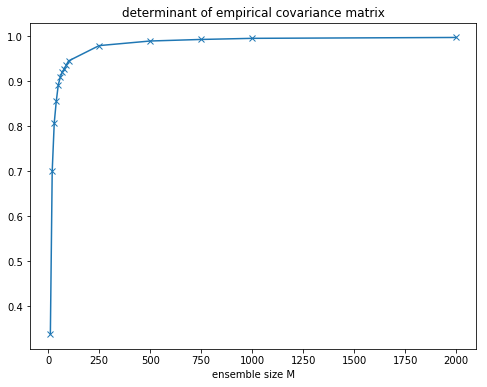

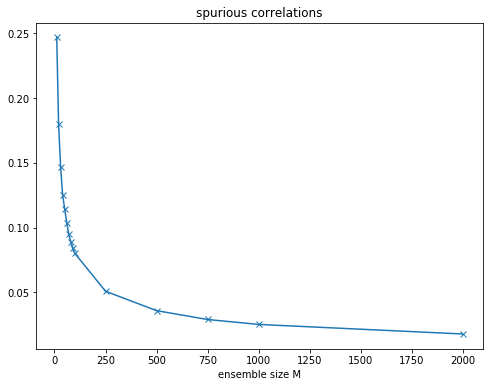

In [4]:
fig0a = plt.figure(figsize=(8,6))
plt.plot(ensemble,D, '-x')
plt.xlabel("ensemble size M")
plt.title("determinant of empirical covariance matrix")
plt.show()

fig0b = plt.figure(figsize=(8,6))
plt.plot(ensemble,C, '-x')
plt.xlabel("ensemble size M")
plt.title("spurious correlations")
plt.show()

### Example 8.4 (Linear advection and method of characteristics)

In [5]:
# define time and step sizes
Dx = 0.01
Dt = 0.001

# define grid lengths
x = np.linspace(0.,1.,100)
t = np.linspace(0.,4.,4000)

# and the corresponding 2D grid
xx, tt = np.meshgrid(x,t)

# set up initial conditions for spatial grid
xk = np.zeros((t.shape[0],x.shape[0]))
xk[0,:] = xx[0,:]

# solve the constant characteristic solution
U = np.sin(2.*np.pi*xx)

# forward Euler for spatial grid
for step in range(t.shape[0] - 1):
    xk[step+1,:] = xk[step,:] + Dt * np.sin(2.*np.pi*xk[step,:]) * np.cos(np.pi*tt[step])

<IPython.core.display.Javascript object>


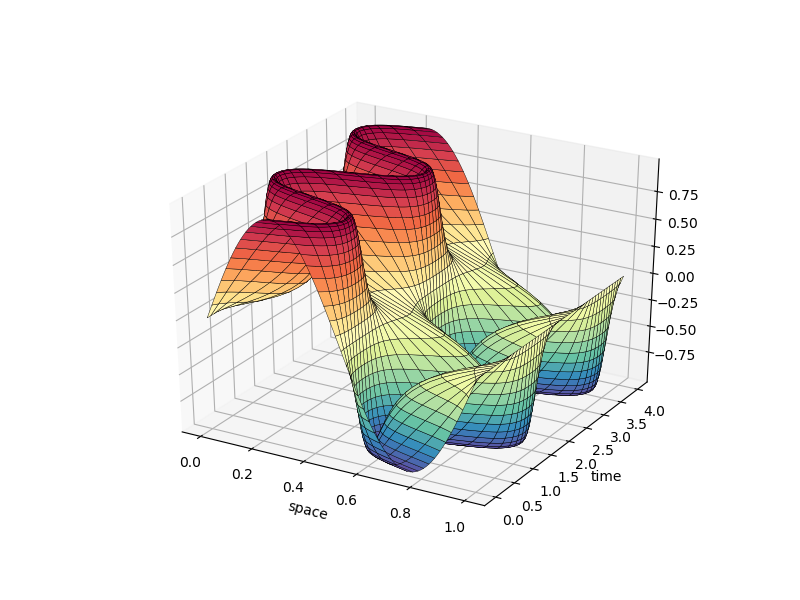

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook

fig1 = plt.figure(figsize=(8,6))
ax = fig1.add_subplot(111, projection='3d')
ax.set_xlabel("space")
ax.set_ylabel("time")
surf = ax.plot_surface(xk,tt,U, cmap=cm.Spectral_r, edgecolors='k', linewidth=0.3, antialiased=True)
plt.show()

### Example 8.5 (Upwind scheme for linear advection)

In [7]:
Dt = 0.01
Dx = 0.01

res = 100
x = np.linspace(0,1,res)
t = np.linspace(0.01,4,res)

xx, tt = np.meshgrid(x,t)
U = np.empty_like(xx) * 0.

# initial condition
U[0,:] = np.sin(2.*np.pi*xx[0,:])

def func_a(x,t):
    return (np.sin(2. * np.pi * x) * np.cos(np.pi * t))

Uleft = np.zeros((x.shape[0]))

for step in range(1,t.shape[0]):
    Uleft[1:] = U[step-1,:-1]
    Uleft[0] = U[step-1,-1]
    U[step,:] = U[step-1,:] - func_a(xx[step-1,:],tt[step-1,:]) * Dt/Dx *  (U[step-1,:] - Uleft)
    RHS = func_a(xx[step-1,:],tt[step-1,:]) * Dt/Dx *  (U[step-1,:] - Uleft)

<IPython.core.display.Javascript object>


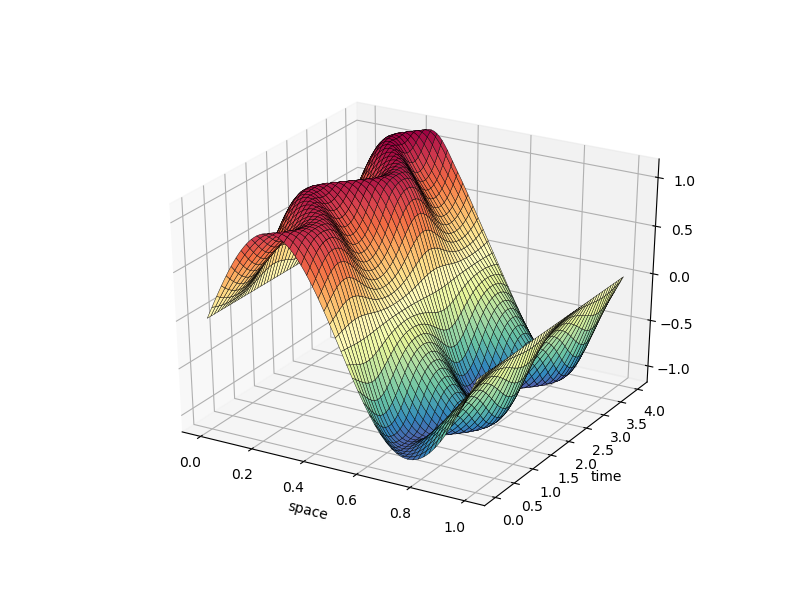

In [8]:
fig2 = plt.figure(figsize=(8,6))
ax = fig2.add_subplot(111, projection='3d')
ax.set_xlabel("space")
ax.set_ylabel("time")
surf = ax.plot_surface(xx,tt,U, cmap=cm.Spectral_r, edgecolors='k', linewidth=0.3, antialiased=True)
plt.show()

### Example 8.6 (leading singular value of a 'stochastic' Burgers' equation)

In [2]:
L = 1.
J = 100
mu = 0.0005

# set step-sizes
dx = 0.01
dt = 0.001

STEPS = 80
INNER = 125

ensemble = [5,10,500,1000]
K = len(ensemble)

xgrid = np.arange(1,J+1)*dx
time = np.zeros((STEPS))
SV = np.zeros((STEPS,K))

for k in range(K):
    M = ensemble[k]
    u = np.zeros((J,M))
    
    Nf = 20
    xi = np.zeros((Nf,M))
    xs = xgrid.reshape((-1,1)) * np.arange(1,Nf+1).reshape((1,-1))
    F = np.sin(2. * np.pi / L * xs)
    D = np.diag(np.arange(1,Nf+1)**2)
    
    e = np.ones((M,1))
    
    for n in range(STEPS):
        for nn in range(INNER):
            xi = xi - dt*np.dot(D,xi) + np.sqrt(dt)*np.random.randn(Nf,M)
            u = u - dt*(np.roll(u,-1,axis=0)**2 - np.roll(u,+1,axis=0)**2) / (4.*dx) + mu*dt*(np.roll(u,-1,axis=0) - 2.*u + np.roll(u,+1,axis=0)) / dx**2 \
                + dt * np.dot(F,xi)
            
        umean = np.dot(u,e)/M
        U = u - umean*e.T
        P = 1./(M-1.) * np.dot(U,U.T)
        SV[n,k] = np.linalg.svd(P,compute_uv=False).max()
        time[n] = INNER*dt*n

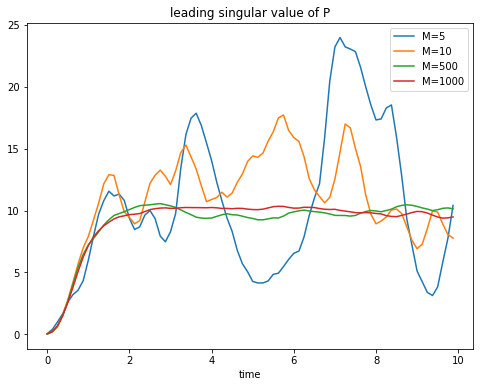

In [3]:
fig3a = plt.figure(figsize=(8,6))
plt.plot(time,SV[:,0])
plt.plot(time,SV[:,1])
plt.plot(time,SV[:,2])
plt.plot(time,SV[:,3])
plt.xlabel("time")
plt.title("leading singular value of P")
plt.legend(["M=5","M=10","M=500","M=1000"])
plt.show()

In [4]:
L = 1.
J = 100
STEPS = 300
INNER = 15

U = np.zeros((J,STEPS+1))
xi0 = np.copy(xi[:,0])
xi0 = xi0.reshape(-1,1)
u0 = np.copy(u[:,0]).reshape(-1,1)
U[:,0] = u0.reshape(-1)

T = 10.
time = np.arange(T,T+STEPS*INNER*dt+dt,dt*INNER)

tt,xx = np.meshgrid(time,xgrid)

for n in range(STEPS):
    for _ in range(INNER):
        xi0 = xi0 - dt*np.dot(D,xi0) + np.sqrt(dt)*np.random.randn(Nf,1)
        u0 = u0 - dt*(np.roll(u0,-1,axis=0)**2 - np.roll(u0,+1,axis=0)**2) / (4.*dx) + mu*dt*(np.roll(u0,-1,axis=0) - 2.*u0 + np.roll(u0,+1,axis=0)) / dx**2 \
                + dt * np.dot(F,xi0)
        
    U[:,n+1] = u0.reshape(-1)

<IPython.core.display.Javascript object>


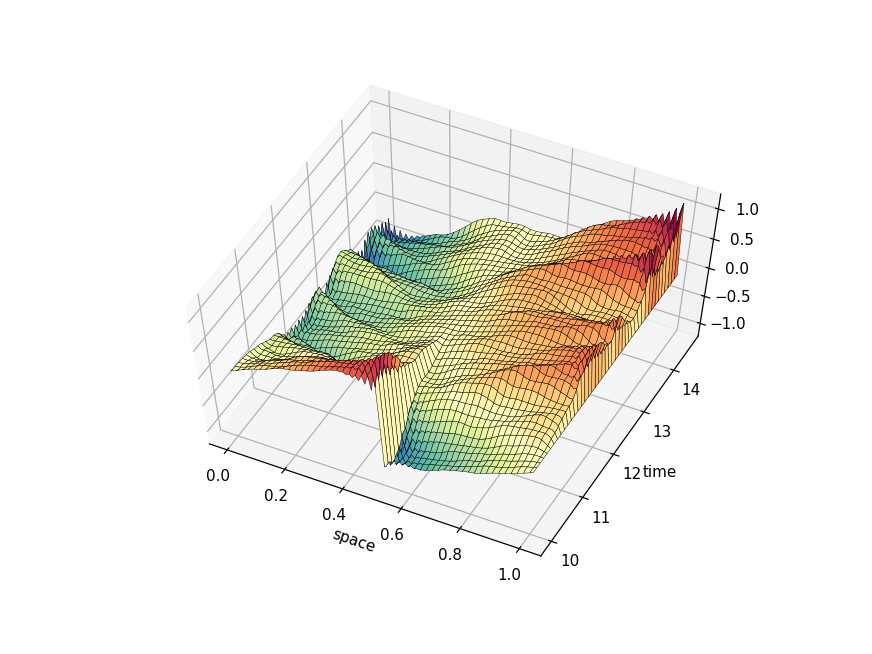

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook

fig3b = plt.figure(figsize=(8,6))
ax = fig3b.add_subplot(111, projection='3d')
ax.set_xlabel("space")
ax.set_ylabel("time")
surf = ax.plot_surface(xx,tt,U, cmap=cm.Spectral_r, edgecolors='k', linewidth=0.3, antialiased=True)
plt.show()

### Example 8.7 (Lorenz-96 model)

In [51]:
# implement numerical time-stepping of equation 8.17
def numerics(u,dx,dt,F):
    um = np.roll(u,-1,axis=0)
    up = np.roll(u,+1,axis=0)
    umm = np.roll(u,-2,axis=0)

    u = u - dt * ((um * up - umm * um)/(3*dx) + u - F)
    return u

In [57]:
J = 100
dx = 1./3
L = dx*J

F = 8.
dt = 0.001

STEPS = 80
INNER = 100

Tend = STEPS*INNER*dt

ensemble = [5,10,500,1000]
K = len(ensemble)

xgrid = dx * np.arange(1,J+1)
SV = np.zeros((STEPS,K))
time = np.zeros((STEPS))

for k in range(K):
    M = ensemble[k]
    u = np.random.randn(J,M)
    
    for n in range(STEPS):
        umean = u.mean(axis=1)
        U = u - umean.reshape(-1,1)
        P = 1./(M-1) * np.dot(U,U.T)
        SV[n,k] = np.linalg.svd(P,compute_uv=False).max()
        time[n] = INNER*dt*n
        
        for _ in range(INNER):
            u = numerics(u,dx,dt,F)

<IPython.core.display.Javascript object>


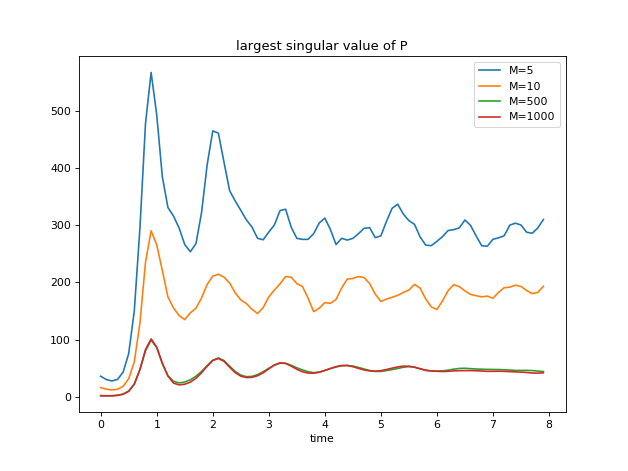

In [58]:
fig4a = plt.figure(figsize=(8,6))
plt.plot(time,SV[:,0])
plt.plot(time,SV[:,1])
plt.plot(time,SV[:,2])
plt.plot(time,SV[:,3])
plt.xlabel("time")
plt.title("largest singular value of P")
plt.legend(["M=5","M=10","M=500","M=1000"])
plt.show()

In [59]:
U = np.zeros((J,STEPS+1))
u0 = np.copy(u[:,0])
U[:,0] = u0
time = np.zeros((STEPS+1))
time[0] = Tend
F = 8.

for n in range(STEPS):
    for _ in range(INNER):
        u0 = numerics(u0,dx,dt,F)
        
    U[:,n+1] = u0
    time[n+1] = Tend + INNER*dt*n
    
tt,xx = np.meshgrid(time,xgrid)

<IPython.core.display.Javascript object>


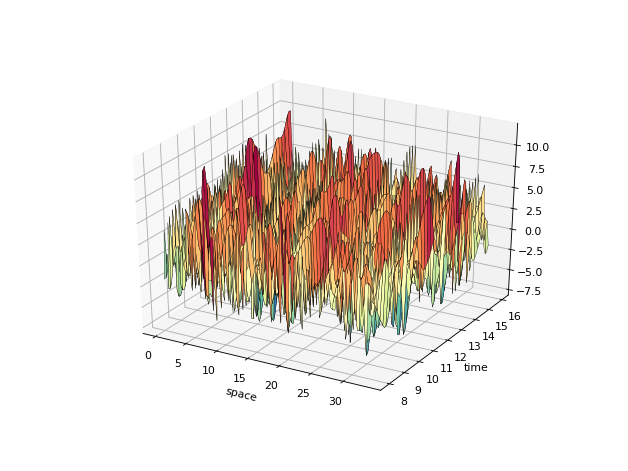

In [60]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook

fig4b = plt.figure(figsize=(8,6))
ax = fig4b.add_subplot(111, projection='3d')
ax.set_xlabel("space")
ax.set_ylabel("time")
surf = ax.plot_surface(xx,tt,U, cmap=cm.Spectral_r, edgecolors='k', linewidth=0.3, antialiased=True)
plt.show()

In [61]:
F = 2.
SV = np.zeros((STEPS,K))
time = np.zeros((STEPS))

for k in range(K):
    M = ensemble[k]
    u = np.random.randn(J,M)
    
    for n in range(STEPS):
        umean = u.mean(axis=1)
        U = u - umean.reshape(-1,1)
        P = 1./(M-1) * np.dot(U,U.T)
        SV[n,k] = np.linalg.svd(P,compute_uv=False).max()
        time[n] = INNER*dt*n
        
        for _ in range(INNER):
            u = numerics(u,dx,dt,F)

<IPython.core.display.Javascript object>


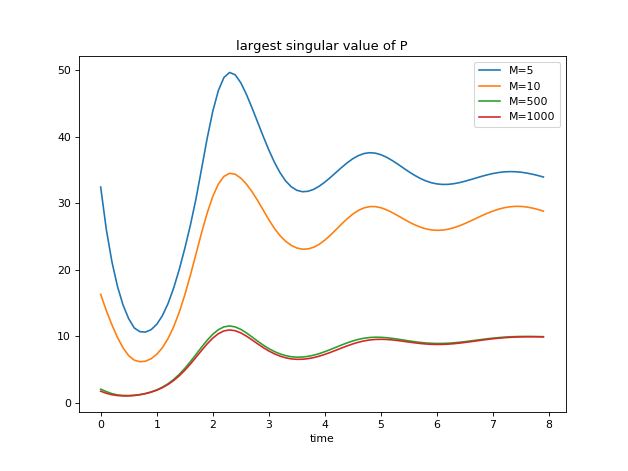

In [62]:
fig4c = plt.figure(figsize=(8,6))
plt.plot(time,SV[:,0])
plt.plot(time,SV[:,1])
plt.plot(time,SV[:,2])
plt.plot(time,SV[:,3])
plt.xlabel("time")
plt.title("largest singular value of P")
plt.legend(["M=5","M=10","M=500","M=1000"])
plt.show()

In [63]:
U = np.zeros((J,STEPS+1))
u0 = np.copy(u[:,0])
U[:,0] = u0
time = np.zeros((STEPS+1))
time[0] = Tend
F = 2.

for n in range(STEPS):
    for _ in range(INNER):
        u0 = numerics(u0,dx,dt,F)
        
    U[:,n+1] = u0
    time[n+1] = Tend + INNER*dt*n
    
tt,xx = np.meshgrid(time,xgrid)

<IPython.core.display.Javascript object>


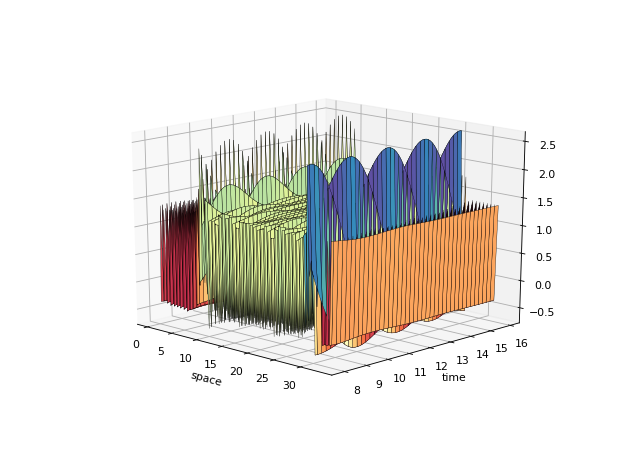

In [65]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib notebook

fig4b = plt.figure(figsize=(8,6))
ax = fig4b.add_subplot(111, projection='3d')
ax.set_xlabel("space")
ax.set_ylabel("time")
surf = ax.plot_surface(xx,tt,U, cmap=cm.Spectral, edgecolors='k', linewidth=0.3, antialiased=True)
plt.show()

## EnKF with perturbed observations and ensemble inflation

### Example 8.9 (Stochastic Burgers' Equation)
Numerical time-stepping of the stochastic Burgers' equation

In [2]:
@jit
def numeric_SDE(xi,D,dt,dx,Nf,M,u,F):
    xi = xi - dt*np.dot(D,xi) + np.sqrt(dt)*np.random.randn(Nf,M)
    u = u - dt*(np.roll(u,-1,axis=0)**2 - np.roll(u,+1,axis=0)**2) / (4.*dx) + 0.0005*dt*(np.roll(u,-1,axis=0) - 2.*u + np.roll(u,+1,axis=0)) / dx**2 \
        + dt * np.dot(F,xi)
    return u,xi

In [6]:
###########
# System parameters and calibration step
###########
L = 1.
Nd = 100
dx = L/float(Nd)
dt = 0.001

STEPS = 5100
Nout = 125
dtobs = dt * Nout
# calibration steps
CAL = 100

Tend = STEPS*Nout*dt
# variance of the measurement errors
R = 0.01

# observation interval of spatial grid
JI = 4

xgrid = np.arange(1,Nd+1).reshape(-1,1)/float(Nd) * L
M = 1 # reference solution has an "ensemble size" of 1

u = np.zeros((Nd,M))
Nf = 20
xi = np.zeros((Nf,M))
D = np.diag(np.arange(1,Nf+1)**2)
xs = np.dot(xgrid,np.arange(1,Nf+1).reshape(1,-1))
F = np.sin(2. * np.pi / L * xs)
e = np.ones((M,1))

for n in range(CAL):
    for _ in range(Nout):
        u,xi = numeric_SDE(xi,D,dt,dx,Nf,M,u,F)

###########
# Data assimilation by EnKF
###########

uinit = np.copy(u)
xiinit = np.copy(xi)

ensemble = [5,10,20,40]
KM = len(ensemble)
LM = 5 # define alpha values range
error = np.zeros((KM,LM))
inflation = np.zeros((KM,LM))

for kl in range(KM):
    for ll in range(LM):
        u = np.copy(uinit)
        xi = np.copy(xiinit)

        M = ensemble[kl]
        e = np.ones((M,1))

        # PP is a matrix to ensure that the mean of the ensemble spread does not change from uninit.
        PP = np.eye(M) - np.dot(e,e.T)/float(M)

        # initial ensemble
        U = np.dot(uinit,e.T) + np.sqrt(0.01) * np.dot(np.random.randn(Nd,M),PP)
        Xi = np.dot(xiinit,e.T)

        for j in range(STEPS):
            for _ in range(Nout):
                # forward reference model
                u,xi = numeric_SDE(xi,D,dt,dx,Nf,1,u,F)
                U,Xi = numeric_SDE(Xi,D,dt,dx,Nf,M,U,F)

            # produce an observation
            yobs = u[::JI] + np.sqrt(R) * np.random.randn(Nd/JI,1)
            Y = np.dot(yobs,e.T)
            
            # state variable
            X = np.vstack((U,Xi))

            # inflation factor dependent on ll.
            alpha = 1.0 + 0.05*ll

            xmean = np.dot(X,e)/float(M)
            dX = np.dot(X,PP)
            dX = alpha * dX
            X = np.dot(xmean,e.T) + dX

            # EnKF (with perturbed observations) -- analysis step
            P = 1./(M-1.) * np.dot(dX,dX.T)
            Kalman = np.dot(P[:,:Nd:JI],np.linalg.inv(P[:Nd:JI,:Nd:JI] + np.eye(Nd/JI)*R))

            # get analysis
            X = X - np.dot(Kalman,(X[:Nd:JI] - Y + np.sqrt(R) * np.dot(np.random.randn(Nd/JI,M),PP)))

            U = X[:Nd,:]
            Xi = X[Nd:,:]

            umean = np.dot(X[:Nd,:],e)/float(M)
            
            if j >= CAL:
                error[kl,ll] = error[kl,ll] + np.linalg.norm((umean-u)/np.sqrt(Nd))**2
                inflation[kl,ll] = inflation[kl,ll] + alpha

        error[kl,ll] = np.sqrt(error[kl,ll] / (j-CAL+1))
        print(error)
        inflation[kl,ll] = inflation[kl,ll] / (j-CAL+1)
        print(inflation)

[[0.08531493 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.08531493 0.07542773 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[1.   1.05 0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
[[0.08531493 0.07542773 0.07053253 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[1.   1.05 1.1  0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]
[[

### Example 8.10 (Lorenz-96 model)

In [201]:
N = 40
dx = 1./3
L = float(N)*dx
xgrid = np.arange(1,N+1).T / float(N) * L

F = 8.
R = 1.

dtobs = 0.1
Nout = 100
dt = dtobs / Nout
CAL = 100
STEPS = 20000 + CAL

uinit = [-1.76,-.66,-2.11,2.02,-2.26,4.57,-0.38,4.35,1.58,2.31 \
         ,1.89,0.13,0.55,2.61,0.22,7.25,0.74,1.89,4.29,-2.47 \
         ,4.61,0.57,1.90,0.28,-0.12,5.25,-0.81,3.70,2.62,0.36 \
         ,-0.84,2.25,0.74,7.27,3.15,-0.14,4.91,0.58,0.89,1.15]

uinit = np.array(uinit).reshape(-1,1)

ensemble = [20,22,24,26]
KM = len(ensemble)
LM = 9
error = np.zeros((KM,LM))
inflation = np.zeros((KM,LM))

for kl in range(KM):
    for ll in range(LM):
        
        u = np.copy(uinit)
        M = ensemble[kl]
        e = np.ones((M,1))
        PP = np.eye(M) - e*e.T/M
        
        # initial ensemble
        X = np.dot(uinit,e.T) + np.sqrt(R) * np.dot(np.random.randn(N,M),PP)
        
        for j in range(STEPS):
            for _ in range(Nout):
                u = numerics(u,dx,dt,F)
                X = numerics(X,dx,dt,F)
                
            yobs = u + np.sqrt(R) * np.random.randn(N,1)
            Y = np.dot(yobs,e.T)
            
            # inflation
            alpha = 1.0 + 0.05 * ll
            xmean = np.dot(X,e)/float(M)
            dX = alpha * np.dot(X,PP)
            X = np.dot(xmean,e.T) + dX
            P = 1./(M-1.) * np.dot(dX,dX.T)
            
            # EnKF (with perturbed observations) -- analysis step
            K = np.dot(P,np.linalg.inv(P + R * np.eye(N)))
            X = X - np.dot(K,(X-Y+np.sqrt(R) * np.dot(np.random.randn(N,M),PP)))
            
            xmean = np.dot(X,e)/float(M)
            
            if j >= CAL:
                error[kl,ll] = error[kl,ll] + np.linalg.norm((xmean-u)/np.sqrt(N))**2
                inflation[kl,ll] = inflation[kl,ll] + alpha
                       
            if STEPS%500==0:
                print(STEPS)
        error[kl,ll] = np.sqrt(error[kl,ll] / (j-CAL+1))
        print(error)
        inflation[kl,ll] = inflation[kl,ll] / (j-CAL+1)
        print(inflation)

[[4.0258065 0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[4.0258065  3.73961601 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
[[1.   1.05 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0. 

KeyboardInterrupt: 

### Example 8.12 (ETPF)
All steps are equivalent to example 8.9 except the analysis part

In [24]:
from scipy.linalg import sqrtm
from pyemd import emd_with_flow

###########
# System parameters and calibration step
###########
L = 1.
Nd = 100
dx = L/float(Nd)
dt = 0.001

STEPS = 5100
Nout = 125
dtobs = dt * Nout
# calibration steps
CAL = 100

Tend = STEPS*Nout*dt
# variance of the measurement errors
R = 0.01

# observation interval of spatial grid
JI = 4

xgrid = np.arange(1,Nd+1).reshape(-1,1)/float(Nd) * L
M = 1 # reference solution has an "ensemble size" of 1

u = np.zeros((Nd,M))
Nf = 20
xi = np.zeros((Nf,M))
D = np.diag(np.arange(1,Nf+1)**2)
xs = np.dot(xgrid,np.arange(1,Nf+1).reshape(1,-1))
F = np.sin(2. * np.pi / L * xs)
e = np.ones((M,1))

for n in range(CAL):
    for _ in range(Nout):
        u,xi = numeric_SDE(xi,D,dt,dx,Nf,M,u,F)

###########
# Data assimilation by ETPF
###########

uinit = np.copy(u)
xiinit = np.copy(xi)

ensemble = [5,10,20,40,100]
KM = len(ensemble)
bandwidth = [0.05,0.1,0.15,0.2]
LM = len(bandwidth)

error = np.zeros((KM,LM))
inflation = np.zeros((KM,LM))

for kl in range(KM):
    M = ensemble[kl]
    e = np.ones((M,1))

    # PP is a matrix to ensure that the mean of the ensemble spread does not change from uninit.
    PP = np.eye(M) - np.dot(e,e.T)/float(M)
    
    for ll in range(LM):
        # initial condition for reference solution
        u = np.copy(uinit)
        xi = np.copy(xiinit)

        # initial ensemble
        U = np.dot(uinit,e.T) + np.sqrt(0.01) * np.dot(np.random.randn(Nd,M),PP)
        Xi = np.dot(xiinit,e.T)

        for j in range(STEPS):
            for _ in range(Nout):
                # forward reference model
                u,xi = numeric_SDE(xi,D,dt,dx,Nf,1,u,F)
                U,Xi = numeric_SDE(Xi,D,dt,dx,Nf,M,U,F)

            # produce an observation
            yobs = u[::JI] + np.sqrt(R) * np.random.randn(Nd/JI,1)
            Y = np.dot(yobs,e.T)
            
            # state variable
            X = np.vstack((U,Xi))

            # particle rejuvenation factor dependent on ll.
            tau = bandwidth[ll]
            dX = np.dot(X,PP)

            # ETPF analysis
            P = 1./(M-1.) * np.dot(dX,dX.T)
            B = tau * P
            
            ##########
            # get analysis
            ##########
            
            # get w weights 
            ww = np.exp(-1.*np.sum((X[:Nd:JI]-Y)**2, axis=0) / (2. * R)).T
            ww /= np.sum(ww)
            
            # calculate transportation cost
            # recall that transportation cost is the difference between the sum of the
            # state variables between two ensemble members squared.
            
            CO = np.zeros((M,M))
            
            for lm in range(Nd):
                xp = X[lm,:].reshape(-1,1)
                d = np.kron(xp,np.ones((1,M)))
                d = (d - d.T)**2
                CO += d
                
            dist, T = emd_with_flow(ww,np.ones(M)/M,CO,-1)
            T = np.array(T)
            T = T*M
            
            X = np.dot(X,T) + np.dot(sqrtm(B).real,np.dot(np.random.randn(Nd+Nf,M),PP))

            U = X[:Nd,:]
            Xi = X[Nd:,:]
            
            ##########
            # end of analysis
            ##########
            
            umean = np.dot(X[:Nd,:],e)/float(M)
            
            if j >= CAL:
                error[kl,ll] = error[kl,ll] + np.linalg.norm((umean-u)/np.sqrt(Nd))**2
                inflation[kl,ll] = inflation[kl,ll] + tau

        error[kl,ll] = np.sqrt(error[kl,ll] / (j-CAL+1))
        print(error)
        inflation[kl,ll] = inflation[kl,ll] / (j-CAL+1)
        print(inflation)

[[0.13462907 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
[[0.05 0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]]
[[0.13462907 0.13342555 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
[[0.05 0.1  0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]]
[[0.13462907 0.13342555 0.1385888  0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
[[0.05 0.1  0.15 0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.

### Example 8.12 (SIR)
Again, all steps are the same as example 8.12 (ETPF), with the exception of the analysis part which uses SIR.

In [42]:
from scipy.linalg import sqrtm
import resampling
reload(resampling)

###########
# System parameters and calibration step
###########
L = 1.
Nd = 100
dx = L/float(Nd)
dt = 0.001

STEPS = 5100
Nout = 125
dtobs = dt * Nout
# calibration steps
CAL = 100

Tend = STEPS*Nout*dt
# variance of the measurement errors
R = 0.01

# observation interval of spatial grid
JI = 4

xgrid = np.arange(1,Nd+1).reshape(-1,1)/float(Nd) * L
M = 1 # reference solution has an "ensemble size" of 1

u = np.zeros((Nd,M))
Nf = 20
xi = np.zeros((Nf,M))
D = np.diag(np.arange(1,Nf+1)**2)
xs = np.dot(xgrid,np.arange(1,Nf+1).reshape(1,-1))
F = np.sin(2. * np.pi / L * xs)
e = np.ones((M,1))

for n in range(CAL):
    for _ in range(Nout):
        u,xi = numeric_SDE(xi,D,dt,dx,Nf,M,u,F)

###########
# Data assimilation by ETPF
###########

uinit = np.copy(u)
xiinit = np.copy(xi)

ensemble = [5,10,20,40,100]
KM = len(ensemble)
bandwidth = [0.05,0.1,0.15,0.2]
LM = len(bandwidth)

error = np.zeros((KM,LM))
inflation = np.zeros((KM,LM))

for kl in range(KM):
    M = ensemble[kl]
    e = np.ones((M,1))

    # PP is a matrix to ensure that the mean of the ensemble spread does not change from uninit.
    PP = np.eye(M) - np.dot(e,e.T)/float(M)
    
    for ll in range(LM):
        # initial condition for reference solution
        u = np.copy(uinit)
        xi = np.copy(xiinit)

        # initial ensemble
        U = np.dot(uinit,e.T) + np.sqrt(0.01) * np.dot(np.random.randn(Nd,M),PP)
        Xi = np.dot(xiinit,e.T)

        for j in range(STEPS):
            for _ in range(Nout):
                # forward reference model
                u,xi = numeric_SDE(xi,D,dt,dx,Nf,1,u,F)
                U,Xi = numeric_SDE(Xi,D,dt,dx,Nf,M,U,F)

            # produce an observation
            yobs = u[::JI] + np.sqrt(R) * np.random.randn(Nd/JI,1)
            Y = np.dot(yobs,e.T)
            
            # state variable
            X = np.vstack((U,Xi))

            # particle rejuvenation factor dependent on ll.
            tau = bandwidth[ll]
            dX = np.dot(X,PP)

            # SIR analysis
            P = 1./(M-1.) * np.dot(dX,dX.T)
            B = tau * P
            
            ##########
            # get analysis
            ##########
            
            # get w weights 
            ww = np.exp(-1.*np.sum((X[:Nd:JI]-Y)**2, axis=0) / (2. * R)).T
            ww /= np.sum(ww)
            
            # resampling            
            A1,B1 = resampling.resampling(X,ww,M,Nd+Nf)
            X = np.hstack((A1,B1))
            
            X = X + np.dot(sqrtm(B).real,np.dot(np.random.randn(Nd+Nf,M),PP))

            U = X[:Nd,:]
            Xi = X[Nd:,:]
            
            ##########
            # end of analysis
            ##########

            umean = np.dot(X[:Nd,:],e)/float(M)
            
            if j >= CAL:
                error[kl,ll] = error[kl,ll] + np.linalg.norm((umean-u)/np.sqrt(Nd))**2
                inflation[kl,ll] = inflation[kl,ll] + tau

        error[kl,ll] = np.sqrt(error[kl,ll] / (j-CAL+1))
        print(error)
        inflation[kl,ll] = inflation[kl,ll] / (j-CAL+1)
        print(inflation)

[[0.13923977 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
[[0.05 0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]]
[[0.13923977 0.13123149 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
[[0.05 0.1  0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]]
[[0.13923977 0.13123149 0.12636929 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
[[0.05 0.1  0.15 0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.

### Example 8.15 (Spatial Correlation Coefficients)
For the stochastic Burgers' equation and the Lorenz-93 model

In [48]:
##### Stochastic Burgers' Equation
# Similar to example 8.9

###########
# System parameters and calibration step
###########
L = 1.
J = 100
dx = L/float(J)
dt = 0.001

STEPS = 5000
INNER = 125

# calibration steps
CAL = 1000

Tend = STEPS*Nout*dt

xgrid = np.arange(1,J+1).reshape(-1,1)/float(J) * L
M = 1 # reference solution has an "ensemble size" of 1

u = np.zeros((J,M))
K = 20
xi = np.zeros((K,M))
D = np.diag(np.arange(1,K+1)**2)
xs = np.dot(xgrid,np.arange(1,K+1).reshape(1,-1))
F = np.sin(2. * np.pi / L * xs)
e = np.ones((M,1))

for n in range(CAL):
    u,xi = numeric_SDE(xi,D,dt,dx,K,M,u,F)

###########
# Data assimilation by EnKF
###########

uinit = np.copy(u)
xiinit = np.copy(xi)

ensemble = [10]
KM = len(ensemble)

Shift = 50
Corr = np.zeros((Shift+1,KM))

for kl in range(KM):
    M = ensemble[kl]
    e = np.ones((M,1))

    # PP is a matrix to ensure that the mean of the ensemble spread does not change from uninit.
    PP = np.eye(M) - np.dot(e,e.T)/float(M)

    # initial ensemble
    U = np.dot(uinit,e.T) + np.sqrt(0.1) * np.dot(np.random.randn(J,M),PP)
    Xi = np.dot(xiinit,e.T)

    for _ in range(STEPS):
        for _ in range(INNER):
            U,Xi = numeric_SDE(Xi,D,dt,dx,K,M,U,F)

        for ll in range(Shift+1):
            UPP = np.dot(U,PP)
            Corr[ll,kl] = Corr[ll,kl] + \
                            1./(float(J)*float(M)) * np.sum(np.diag(np.dot(np.roll(UPP,ll,axis=0),UPP.T)))
    
    Corr = Corr[:,kl] / Corr[0,kl]

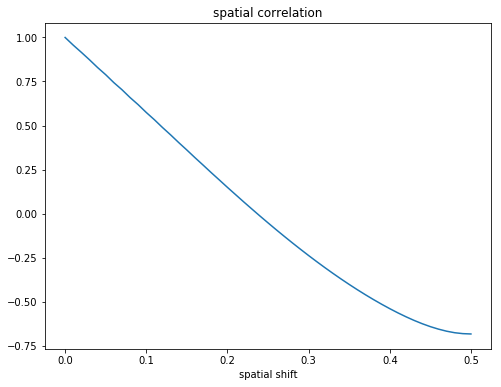

In [49]:
fig5a = plt.figure(figsize=(8,6))
plt.plot(np.arange(0,Shift+1)*dx,Corr)
plt.xlabel("spatial shift")
plt.title("spatial correlation")
plt.show()

In [57]:
##### Lorenz-96 Model
# Similar to example 8.10

J = 40
dx = 1./3
L = float(J)*dx
xgrid = np.arange(1,J+1).T / float(J) * L

F = 8.

dtobs = 0.05
Inner = 50
dt = dtobs / float(Inner)
CAL = 1000
STEPS = 5000

u = np.random.randn(J,1)

for _ in range(CAL):
    u = numerics(u,dx,dt,F)

uinit = np.copy(u)

ensemble = [10]
K = len(ensemble)

Shift = 20
Corr = np.zeros((Shift+1,K))

for kl in range(K):
    M = ensemble[kl]
    e = np.ones((M,1))
    PP = np.eye(M) - e*e.T/M

    X = np.dot(uinit,e.T) + 0.1 * np.dot(np.random.randn(J,M),PP)

    for _ in range(STEPS):
        for _ in range(Inner):
            X = numerics(X,dx,dt,F)

        for ll in range(Shift+1):
            XPP = np.dot(X,PP)
            Corr[ll,kl] = Corr[ll,kl] + 1./(float(J)*float(M)) * np.sum(np.diag(np.dot(np.roll(XPP,ll,axis=0),XPP.T)))
            
    Corr = Corr[:,kl] / Corr[0,kl]

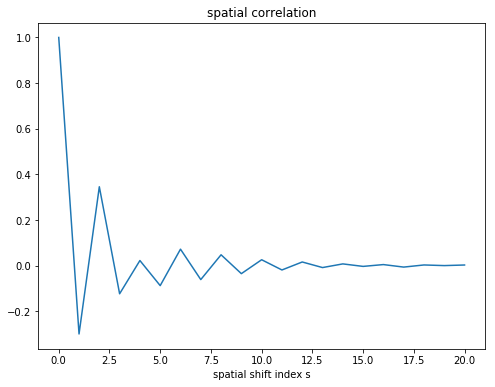

In [58]:
fig5b = plt.figure(figsize=(8,6))
plt.plot(np.arange(0,Shift+1),Corr)
plt.xlabel("spatial shift index s")
plt.title("spatial correlation")
plt.show()

### Example 8.19 (B-Localisation of the Lorenz-96 Model)

filt is a function of s (eqn 8.28), where s is
$$ s := \frac{r_{k,k^\prime}}{r_{loc}} \geq 0, $$
and $r_{loc}$ is `locRad` $\times \Delta x$. 

Since the domain is periodic, the distance function is smallest when the neighbouring element is itself, and the largest when the neighbouring element is half a domain length away. Assuming that we are looking at the first element, this is the array `x`. Now, apply the filtering function on `x`.

Then, because the filtering function applies to all elements equally, roll it for each subsequent element in the spatial grid. This gives `CC1`. The Schur product of `Ploc` is the localised background covariance matrix.

In [78]:
##########
# Copied example 8.10 for the Lorenz-96 model with EnKF analysis and ensemble inflation
##########

N = 40
dx = 1./3
L = float(N)*dx
xgrid = np.arange(1,N+1).T / float(N) * L

F = 8.
R = 8.

dtobs = 0.11
Nout = 110
dt = dtobs / Nout
CAL = 100
STEPS = 400 + CAL

uinit = [-1.76,-.66,-2.11,2.02,-2.26,4.57,-0.38,4.35,1.58,2.31 \
         ,1.89,0.13,0.55,2.61,0.22,7.25,0.74,1.89,4.29,-2.47 \
         ,4.61,0.57,1.90,0.28,-0.12,5.25,-0.81,3.70,2.62,0.36 \
         ,-0.84,2.25,0.74,7.27,3.15,-0.14,4.91,0.58,0.89,1.15]

uinit = np.array(uinit).reshape(-1,1)

ensemble = [10,20,30,40,50,60,70,80]
KM = len(ensemble)
LM = 7
error = np.zeros((KM,LM))
inflation = np.zeros((KM,LM))

# generate forward operator
p = 2 # observe every p-th grid point
H = np.zeros((N/p,N))

for j in range(N/p):
    H[j,p*j] = 1.

locRad = 10.

# largest value of d(i,j) = L/2 because of the periodicity.
x = np.hstack((np.arange(0,N/2+1),np.arange(1,N/2)[::-1]))/locRad

# apply piecewise polynomial filter of (eqn 8.29).
filt = np.zeros(len(x))
ind = np.where(x <= 1.)
z = x[ind]
filt[ind] = -1./4 * z**5 + 1./2 * z**4 + 5./8 * z**3 - 5./3 * z**2 + 1.
ind = np.where((x > 1.) & (x <= 2.))
z = x[ind]
filt[ind] = 1./12 * z**5 - 1./2 * z**4 + 5./8 * z**3 + 5./3 * z**2 - 5. * z + 4 - 2./(3. * z) 

CC1 = np.zeros((N,N))
for j in range(N):
    CC1[j,:] = np.roll(filt,j)

for kl in range(KM):
    for ll in range(LM):

        u = np.copy(uinit)
        M = ensemble[kl]
        e = np.ones((M,1))
        PP = np.eye(M) - e*e.T/M

        # initial ensemble
        X = np.dot(uinit,e.T) + np.sqrt(R) * np.dot(np.random.randn(N,M),PP)

        for j in range(STEPS):
            for _ in range(Nout):
                u = numerics(u,dx,dt,F)
                X = numerics(X,dx,dt,F)

            yobs = np.dot(H,u) + np.sqrt(R) * np.random.randn(N/p,1)
            Y = np.dot(yobs,e.T)

            # inflation
            alpha = 1.0 + 0.02 * ll
            
            xmean = np.dot(X,e)/float(M)
            dX = alpha * np.dot(X,PP)
            X = np.dot(xmean,e.T) + dX
            P = 1./(M-1.) * np.dot(dX,dX.T)

            # EnKF with B-localisation
            Ploc = CC1 * P
            PlocHT = np.dot(Ploc,H.T)
            K = np.dot(PlocHT,np.linalg.inv(np.dot(H,PlocHT) + R * np.eye(N/p)))
            X = X - np.dot(K,(np.dot(H,X)-Y+np.sqrt(R) * np.dot(np.random.randn(N/p,M),PP)))

            xmean = np.dot(X,e)/float(M)

            if j >= CAL:
                error[kl,ll] = error[kl,ll] + np.linalg.norm((xmean-u)/np.sqrt(N))**2
                inflation[kl,ll] = inflation[kl,ll] + alpha
                
        error[kl,ll] = np.sqrt(error[kl,ll] / (j-CAL+1))
        print(error)
        inflation[kl,ll] = inflation[kl,ll] / (j-CAL+1)
        print(inflation)

[[3.6443544 0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.       ]]
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[3.6443544  3.23917063 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]


[[3.6443544  3.23917063 3.32605981 2.93105078 2.31302714 2.42855158
  2.21316132]
 [3.18633463 2.50639142 2.13441014 1.73312666 0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]
[[3.6443544  3.23917063 3.32605981 2.93105078 2.31302714 2.42855158
  2.21316132]
 [3.18633463

[[3.6443544  3.23917063 3.32605981 2.93105078 2.31302714 2.42855158
  2.21316132]
 [3.18633463 2.50639142 2.13441014 1.73312666 1.82455798 1.81077232
  1.82926147]
 [2.87944768 1.74547878 1.49432522 1.58555519 1.68878598 1.75706543
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]
[[3.6443544  3.23917063 3.32605981 2.93105078 2.31302714 2.42855158
  2.213161

[[3.6443544  3.23917063 3.32605981 2.93105078 2.31302714 2.42855158
  2.21316132]
 [3.18633463 2.50639142 2.13441014 1.73312666 1.82455798 1.81077232
  1.82926147]
 [2.87944768 1.74547878 1.49432522 1.58555519 1.68878598 1.75706543
  1.72777393]
 [2.33945634 1.55082673 1.44334503 1.64602256 1.67620009 1.6714434
  1.70536629]
 [1.69385914 0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]
[[3.6443544  3.23917063 3.32605981 2.93105078 2.31302714 2.42855158
  2

[[3.6443544  3.23917063 3.32605981 2.93105078 2.31302714 2.42855158
  2.21316132]
 [3.18633463 2.50639142 2.13441014 1.73312666 1.82455798 1.81077232
  1.82926147]
 [2.87944768 1.74547878 1.49432522 1.58555519 1.68878598 1.75706543
  1.72777393]
 [2.33945634 1.55082673 1.44334503 1.64602256 1.67620009 1.6714434
  1.70536629]
 [1.69385914 1.59025521 1.62574328 1.56181962 1.58390667 1.69279539
  1.85510012]
 [1.78641816 1.56968843 1.46786785 0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]
[[3.6443544  3.23917063 3.32605981 2.93105078 2.31302714 2.4285

[[3.6443544  3.23917063 3.32605981 2.93105078 2.31302714 2.42855158
  2.21316132]
 [3.18633463 2.50639142 2.13441014 1.73312666 1.82455798 1.81077232
  1.82926147]
 [2.87944768 1.74547878 1.49432522 1.58555519 1.68878598 1.75706543
  1.72777393]
 [2.33945634 1.55082673 1.44334503 1.64602256 1.67620009 1.6714434
  1.70536629]
 [1.69385914 1.59025521 1.62574328 1.56181962 1.58390667 1.69279539
  1.85510012]
 [1.78641816 1.56968843 1.46786785 1.55286953 1.630078   1.65436596
  1.80455165]
 [2.3045257  1.69180355 1.54388304 1.57066536 1.62745017 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]
[[3.6443544  3.23917063 3.32605981 2.93105078 2.3130271

[[3.6443544  3.23917063 3.32605981 2.93105078 2.31302714 2.42855158
  2.21316132]
 [3.18633463 2.50639142 2.13441014 1.73312666 1.82455798 1.81077232
  1.82926147]
 [2.87944768 1.74547878 1.49432522 1.58555519 1.68878598 1.75706543
  1.72777393]
 [2.33945634 1.55082673 1.44334503 1.64602256 1.67620009 1.6714434
  1.70536629]
 [1.69385914 1.59025521 1.62574328 1.56181962 1.58390667 1.69279539
  1.85510012]
 [1.78641816 1.56968843 1.46786785 1.55286953 1.630078   1.65436596
  1.80455165]
 [2.3045257  1.69180355 1.54388304 1.57066536 1.62745017 1.68867759
  1.81793772]
 [1.70489716 1.48872458 1.56908086 1.61107054 1.6504298  1.70192404
  1.80770904]]
[[1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]
 [1.   1.02 1.04 1.06 1.08 1.1  1.12]]
